In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

import pandas_datareader.data as web
import datetime
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [3]:
def evaluacion (activo,start,pred_size,lags):
    tipo = 0
    start = datetime.datetime.strptime(start,"%Y, %m, %d" )
    end = datetime.datetime.now()
    df = web.get_data_yahoo(activo, start, end, interval="m")
    df = df[["Close","Volume"]]
    
    df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
    df['log_value'] = np.log(df['Close'])
    df["sqrt"] = np.sqrt(df["Close"])
    df['month'] = [d.strftime('%b') for d in df.index]
    dummies_mes = pd.get_dummies(df['month'],drop_first=True)
    df = df.join(dummies_mes)
    
    df_train, df_test = train_test_split(df, test_size=pred_size, random_state=42, shuffle=False)
    
    model_log_est = smf.ols('log_value ~ timeIndex + Volume + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep ',data = df_train).fit()
    
    df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


    df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])
    
    df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
    df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])
    res_model = df_train['Close'] - df_train['back_model_log_est']
    res_log_est = df_train['log_value'] - df_train['model_log_est']
    result = adfuller(res_model)
    result1 = adfuller(res_log_est)
    if result[1]<0.05:
        print("elegimos el residuo del precio de cierre - exp(log est) - p=",result[1])
        modelo = res_model
        tsplot (res_model,lags=lags)
        tipo = 1
    elif result1[1]<0.05:
        print("elegimos el residuo del log precio de cierre - log est - p=",result1[1])
        modelo = res_log_est
        tsplot (res_log_est,lags=lags)
        tipo = 2
    else:
        print("la serie no es estacionaria, hacer mas diferenciación")
    return (modelo,df_train,df_test,tipo)

In [4]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [5]:
def arima (modelo,p,d,q,alpha):
    model_ARIMA = ARIMA(modelo[0], order=(p,d,q))
    results_ARIMA = model_ARIMA.fit()
    res_ARIMA =  results_ARIMA.fittedvalues - modelo[0]
    predictions_ARIMA, se, conf = results_ARIMA.forecast(len(modelo[2]['Close']), alpha=alpha)
    if modelo[3] == 1:
        modelo[1]['model_ARIMA'] = modelo[1]['back_model_log_est'] + results_ARIMA.fittedvalues
        modelo[2]['model_ARIMA'] = modelo[2]['back_model_log_est'] + predictions_ARIMA
    else:
        modelo[1]['model_ARIMA'] = np.exp(modelo[1]['model_log_est'] + results_ARIMA.fittedvalues)
        modelo[2]['model_ARIMA'] = np.exp(modelo[2]['model_log_est'] + predictions_ARIMA)
    modelo[1].plot(kind = "line", y = ['Close', 'model_ARIMA']);
    modelo[2].plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [32]:
modelo = evaluacion("eth-usd","2015, 1, 1",6,20)

la serie no es estacionaria, hacer mas diferenciación


UnboundLocalError: local variable 'modelo' referenced before assignment

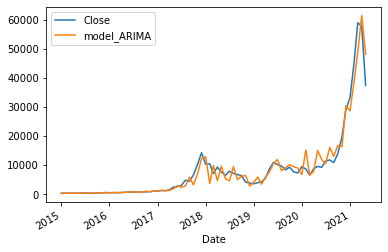

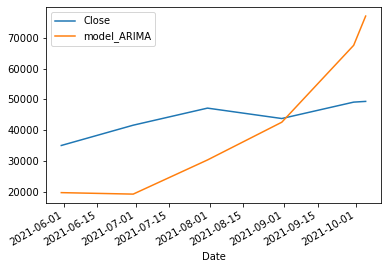

In [31]:
arima(modelo,2,0,2,0.05)

#para abajo es codigo repetido o que no utilicé arriba!

In [122]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
df = web.get_data_yahoo("ko", start, end, interval="m")
df = df[["Close","Volume"]]

In [123]:
df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
df['log_value'] = np.log(df['Close'])
df["sqrt"] = np.sqrt(df["Close"])

df['month'] = [d.strftime('%b') for d in df.index]
#df["day"] = [d.strftime('%d') for d in df.index]
dummies_mes = pd.get_dummies(df['month'],drop_first=True)
#dummies_dia = pd.get_dummies(df['day'],drop_first=True,prefix="day")
df = df.join(dummies_mes)
#df = df.join(dummies_dia)


In [124]:
df.tail()

,Close,Volume,timeIndex,log_value,sqrt,month,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,,,
2021-05-01,55.290001,309903200.0,136,4.012592,7.435725,May,0,0,0,0,0,0,0,1,0,0,0
2021-06-01,54.110001,305857700.0,137,3.991019,7.355950,Jun,0,0,0,0,0,1,0,0,0,0,0
2021-07-01,57.029999,293385300.0,138,4.043577,7.551821,Jul,0,0,0,0,1,0,0,0,0,0,0
2021-08-01,56.310001,220328500.0,139,4.030872,7.503999,Aug,1,0,0,0,0,0,0,0,0,0,0
2021-09-01,52.470001,334489500.0,140,3.960242,7.243618,Sep,0,0,0,0,0,0,0,0,0,0,1


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141 entries, 2010-01-01 to 2021-09-01
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      141 non-null    float64
 1   Volume     141 non-null    float64
 2   timeIndex  141 non-null    int32  
 3   log_value  141 non-null    float64
 4   sqrt       141 non-null    float64
 5   month      141 non-null    object 
 6   Aug        141 non-null    uint8  
 7   Dec        141 non-null    uint8  
 8   Feb        141 non-null    uint8  
 9   Jan        141 non-null    uint8  
 10  Jul        141 non-null    uint8  
 11  Jun        141 non-null    uint8  
 12  Mar        141 non-null    uint8  
 13  May        141 non-null    uint8  
 14  Nov        141 non-null    uint8  
 15  Oct        141 non-null    uint8  
 16  Sep        141 non-null    uint8  
dtypes: float64(4), int32(1), object(1), uint8(11)
memory usage: 12.7+ KB


In [125]:
# Dividimos en train y test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=6, random_state=42, shuffle=False)

In [126]:
model_log_est = smf.ols('log_value ~ timeIndex + Volume + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep ',data = df_train).fit()

In [127]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [128]:
# Recuperamos el valor predicho aplicando la función exponencial sobre las predicciones.
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

Resiudos del modelo

In [58]:
res_model = df_train['Close'] - df_train['back_model_log_est']

plt.plot(df_train.timeIndex, res_model, '-');

NameError: name 'df_train' is not defined

In [130]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -3.880247
p-value: 0.002185
Valor crítico 1%: -3.48
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


Residuos del logaritmo

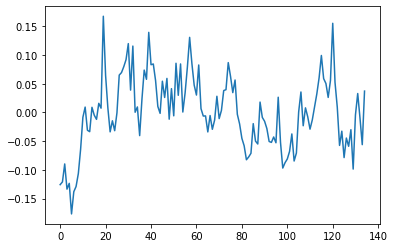

In [131]:
res_log_est = df_train['log_value'] - df_train['model_log_est']

plt.plot(df_train.timeIndex, res_log_est, '-');

In [132]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -3.722735
p-value: 0.003804
Valor crítico 1%: -3.48
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


Residuos de la raiz cuadrada

In [133]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [134]:
lag_acf = acf(res_model, nlags = 20)
lag_acf

array([1.        , 0.69189062, 0.56751105, 0.42459255, 0.36829496,
       0.25492901, 0.21331142, 0.11625883, 0.10473185, 0.05179365,
       0.08209223, 0.09470054, 0.05877816, 0.03772274, 0.03698997,
       0.05056691, 0.03781082, 0.05624343, 0.0549437 , 0.08189789,
       0.04414969])

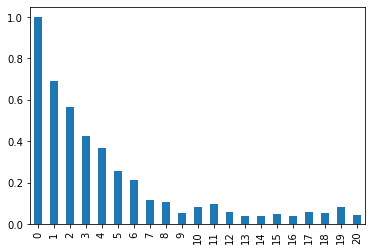

In [135]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [136]:
lag_pacf = pacf(res_model, nlags=20, method='ols');

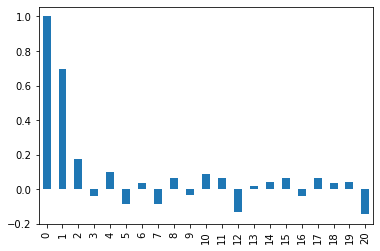

In [137]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

In [138]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

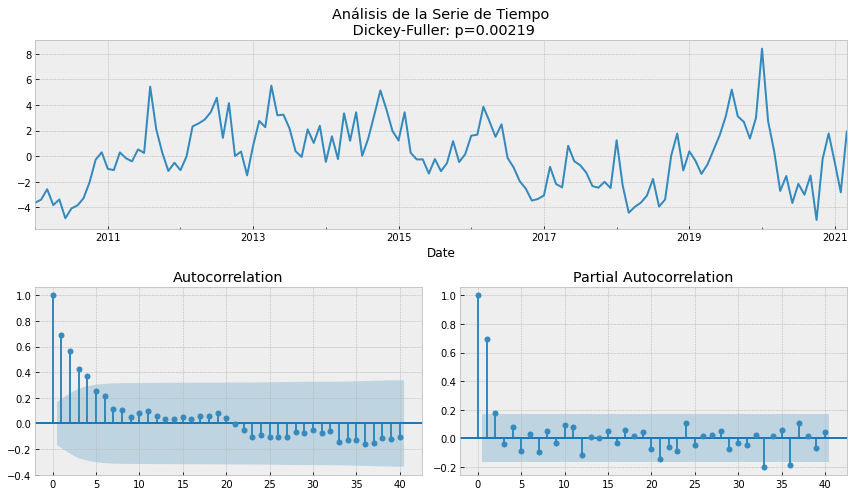

In [139]:
tsplot(res_model, lags=40)

In [109]:
from statsmodels.tsa.arima_model import ARIMA

In [140]:
model_ARIMA = ARIMA(res_model, order=(2,0,4))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

Date
2010-01-01   -0.003947
2010-02-01   -2.546915
2010-03-01   -2.594260
2010-04-01   -2.045388
2010-05-01   -2.746495
dtype: float64

In [141]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  135
Model:                     ARMA(2, 4)   Log Likelihood                -268.266
Method:                       css-mle   S.D. of innovations              1.759
Date:                Fri, 01 Oct 2021   AIC                            552.533
Time:                        01:46:10   BIC                            575.775
Sample:                    01-01-2010   HQIC                           561.978
                         - 03-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.603     -0.007      0.995      -1.185       1.177
ar.L1.y       -0.0459      0.163     -0.282      0.778      -0.365       0.274
ar.L2.y        0.6585      0.150      4.392      0.0

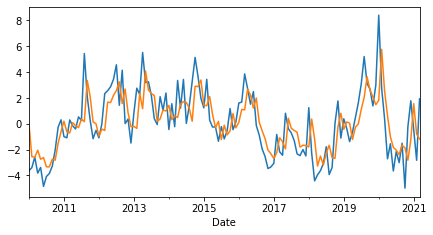

In [142]:
plt.figure(figsize=(7,3.5))
res_model.plot()
results_ARIMA.fittedvalues.plot();

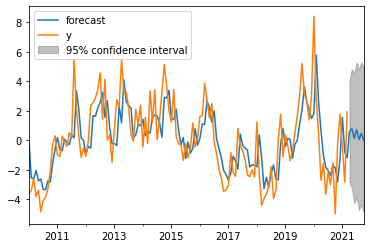

In [143]:
results_ARIMA.plot_predict(end=len(df['Close']));

In [144]:
res_ARIMA =  results_ARIMA.fittedvalues - res_model

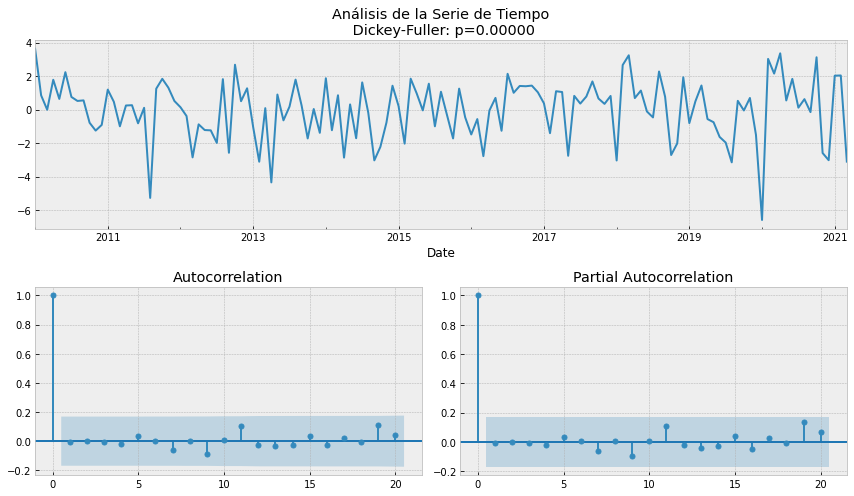

In [145]:
tsplot(res_ARIMA, lags=20)

In [146]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['Close']), alpha=0.05)

In [147]:
df_train['model_ARIMA'] = df_train['back_model_log_est'] + results_ARIMA.fittedvalues

correccion = + df_train.Close.tail(1)[0] - df_train.model_ARIMA.tail(1)[0]

df_test['model_ARIMA'] = df_test['back_model_log_est'] + predictions_ARIMA


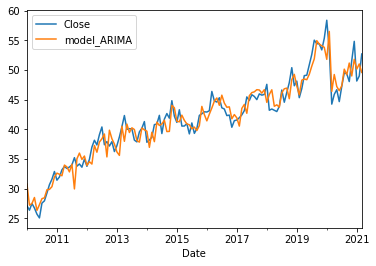

In [148]:
df_train.plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [149]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [150]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Model + est + ARIMA"
df_Results.loc[0, "RMSE"] = RMSE(df_test['model_ARIMA'], df_test['Close'])
df_Results

,Model,RMSE
0,Model + est + ARIMA,1.792892


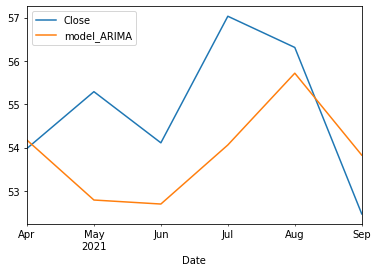

In [151]:
df_test.plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [37]:
df_test

,Close,timeIndex,log_value,sqrt,month,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model_log_est,back_model_log_est,model_ARIMA
Date,,,,,,,,,,,,,,,,,,,
2021-04-01,57.790001,135,4.056816,7.601973,Apr,0,0,0,0,0,0,0,0,0,0,0,4.141233,62.880279,58.823706
2021-05-01,56.490002,136,4.034064,7.515983,May,0,0,0,0,0,0,0,1,0,0,0,4.125586,61.904090,57.917009
2021-06-01,56.029999,137,4.025887,7.485319,Jun,0,0,0,0,0,1,0,0,0,0,0,4.140321,62.822965,59.398797
2021-07-01,55.779999,138,4.021415,7.468601,Jul,0,0,0,0,1,0,0,0,0,0,0,4.157296,63.898513,60.348802
2021-08-01,55.000000,139,4.007333,7.416198,Aug,1,0,0,0,0,0,0,0,0,0,0,4.155986,63.814886,60.510667
2021-09-01,54.009998,140,3.989169,7.349149,Sep,0,0,0,0,0,0,0,0,0,0,1,4.170067,64.719761,61.459461


In [ ]:
df_train.Close.tail(1)[0] - df_train.model_ARIMA.tail(1)[0]